# Create a word2vec model

CBOW is a common project used to teach NLP and embedding. I recreated this project for my own benefit and added comments throughout this 
detailing my thought process.


[CBOW structure from https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/]

In [ ]:
import pandas as pd
import string
import Word2VecSupport

def clean_text(text):    
    x = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    x = x.lower().split() # lower case and split by whitespace to differentiate words
    return x

example_text = pd.read_csv('text.csv')
cleaned_text = example_text.Review[:100].apply(clean_text)

### Data Description
`example_text` has 1000 pieces of text message. The first 5 pieces of message are shown in the following.

Since there exist punctuation in `example_text`, we use `cleaned_text` function to remove them and also set all words to lower case and split them ny whitespace.

In [3]:
print(example_text.count())
example_text.head()

Review    1000
dtype: int64


,Review
0,Wow... Loved this place.
1,Crust is not good.
2,Not tasty and the texture was just nasty.
3,Stopped by during the late May bank holiday of...
4,The selection on the menu was great and so wer...


In [4]:
cleaned_text.head()

0                            [wow, loved, this, place]
1                               [crust, is, not, good]
2    [not, tasty, and, the, texture, was, just, nasty]
3    [stopped, by, during, the, late, may, bank, ho...
4    [the, selection, on, the, menu, was, great, an...
Name: Review, dtype: object

### Creating the CBOW Class

To do this I establish `vocab` and `word_to_index`.

Here, to create unique vocabulary, each word in `cleaned_text` was checked through nested for loops and the `set()` function was used to delete redundant words.

The resulting `vocab` has a size of 483, which means there is in total 483 unique words in `cleaned_text`. 

`word_to_index` was a dictionary created to give all 483 words an index number.

In [5]:
intermid = []
for i in range(len(cleaned_text)):
    for j in range(len(cleaned_text[i])):
        intermid.append(cleaned_text[i][j])
vocab = set(intermid)
vocab = list(vocab)

word2Vec = Word2VecSupport.Word2Vec(vocab)


In [6]:
cleaned_text[0]

['wow', 'loved', 'this', 'place']

In [7]:
word2Vec.make_cbow_data(['the', 'food', 'was', 'not', 'good', 'at', 'all'], 2, word2Vec.word_to_index_dictionary)

[(tensor([420, 136, 307, 169]), tensor([54])),
 (tensor([136,  54, 169, 187]), tensor([307])),
 (tensor([ 54, 307, 187,  16]), tensor([169]))]

In [8]:
word2Vec.word_to_index_dictionary

{'where': 0,
 'selection': 1,
 'down': 2,
 'sunglasses': 3,
 'by': 4,
 'made': 5,
 'first': 6,
 'that': 7,
 'any': 8,
 'known': 9,
 'hiro': 10,
 'they': 11,
 'seems': 12,
 'quite': 13,
 'familiar': 14,
 'times': 15,
 'all': 16,
 'refill': 17,
 'firehouse': 18,
 'combos': 19,
 'bland': 20,
 'beyond': 21,
 'ahead': 22,
 'happier': 23,
 'sashimi': 24,
 'think': 25,
 'more': 26,
 'ravoli': 27,
 'in': 28,
 'blah': 29,
 'die': 30,
 'if': 31,
 'meat': 32,
 'will': 33,
 'grease': 34,
 'overwhelmed': 35,
 'dont': 36,
 'fries': 37,
 'ended': 38,
 'least': 39,
 'person': 40,
 'yourself': 41,
 'bye': 42,
 'restaurant': 43,
 'chewy': 44,
 'cakeohhh': 45,
 'deal': 46,
 'sauce': 47,
 'waitress': 48,
 'a': 49,
 'year': 50,
 'attack': 51,
 'your': 52,
 'palate': 53,
 'was': 54,
 'taste': 55,
 'rolls': 56,
 'overpriced': 57,
 'tastings': 58,
 'hole': 59,
 '5': 60,
 'prime': 61,
 'rib': 62,
 'an': 63,
 'buffet': 64,
 'honeslty': 65,
 'during': 66,
 'cashier': 67,
 'bank': 68,
 'also': 69,
 'batter': 70,


In [9]:
# Define your CBOW model here (TODO)
import torch
class CBOW(torch.nn.Embedding):
    def __init__(self, vocabLen, embedDim, windowSize, hiddenDim):
        super(CBOW, self).__init__(vocabLen, embedDim)
        self.embedding = torch.nn.Embedding(num_embeddings = vocabLen, embedding_dim= embedDim)
        self.fullyConnected1 = torch.nn.Linear(embedDim, hiddenDim)
        self.fullyConnected2 = torch.nn.Linear(hiddenDim, vocabLen)
    
    def forward(self, x):
        x = self.embedding(x)
        x = sum(x).view(1,-1)
        x = self.fullyConnected1(x)
        x = self.fullyConnected2(x)

        return torch.nn.functional.log_softmax(x,dim=1)



## Train the CBOW model

Now I train my CBOW model for 300 epochs with `embed_dim`= 100, `window_size`=2, and `hidden_dim`=30. 
- Since I am not evaluating the performance of this model I don't split the train and test set. 
- I use the SGD optimizer with learning rate = 0.001.
- I append the loss at every epoch so that I can plot it later. 

In [ ]:
# Parameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
WINDOW_SIZE = 2
HIDDEN_DIM = 30
N_EPOCHS = 300

# Construct input data
data = word2Vec.createTupleList(cleaned_text, WINDOW_SIZE, word2Vec.word_to_index_dictionary)

#Training
network = CBOW(VOCAB_SIZE, EMBED_DIM, WINDOW_SIZE, HIDDEN_DIM)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)
losses = []

for epoch in range(N_EPOCHS):
    totLoss = 0
    for X, target in data:
        ypred = network(X)
        loss = loss_func(ypred, target)
        totLoss += loss
    optimizer.zero_grad()
    totLoss.backward()
    optimizer.step()
    losses.append(totLoss)

    if epoch % 10 == 0 and epoch != 0:
        print("epoch: ", epoch, "total_loss = ", totLoss.cpu().detach())


epoch:  10 total_loss =  tensor(2971.6438)
epoch:  20 total_loss =  tensor(1986.0261)
epoch:  30 total_loss =  tensor(1132.3273)
epoch:  40 total_loss =  tensor(556.7875)
epoch:  50 total_loss =  tensor(284.4713)
epoch:  60 total_loss =  tensor(162.5016)
epoch:  70 total_loss =  tensor(104.4174)
epoch:  80 total_loss =  tensor(74.6776)
epoch:  90 total_loss =  tensor(57.1837)
epoch:  100 total_loss =  tensor(45.8146)
epoch:  110 total_loss =  tensor(37.9298)
epoch:  120 total_loss =  tensor(32.1874)
epoch:  130 total_loss =  tensor(27.8437)
epoch:  140 total_loss =  tensor(24.4575)
epoch:  150 total_loss =  tensor(21.7526)
epoch:  160 total_loss =  tensor(19.5479)
epoch:  170 total_loss =  tensor(17.7201)
epoch:  180 total_loss =  tensor(16.1828)
epoch:  190 total_loss =  tensor(14.8737)
epoch:  200 total_loss =  tensor(13.7470)
epoch:  210 total_loss =  tensor(12.7679)
epoch:  220 total_loss =  tensor(11.9101)
epoch:  230 total_loss =  tensor(11.1528)
epoch:  240 total_loss =  tensor(

In [11]:
data[:5]

[(tensor([307, 143, 420, 115]), tensor([82])),
 (tensor([143,  82, 115,  54]), tensor([420])),
 (tensor([ 82, 420,  54, 433]), tensor([115])),
 (tensor([420, 115, 433, 292]), tensor([54])),
 (tensor([281,   4, 420, 185]), tensor([66]))]

## Plot losses by epochs (x-axis: epoch, y-axis: loss)

Matplotlib is building the font cache; this may take a moment.


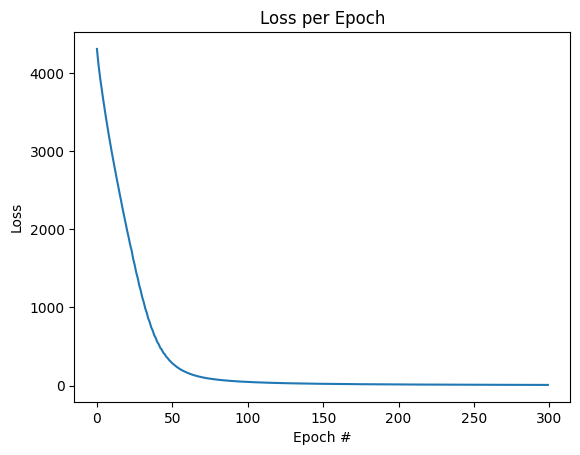

In [ ]:
import matplotlib.pyplot as plt
loss_list = []
for loss in losses:
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.title("Loss per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

## Print five most similar words with the word "banana"

In [ ]:
import sklearn.metrics

#The Steps I take are as follows:
# Extract vectors containing meaning for all words
# Find vector which contains meaning of word (in this case I look for the word 'banana')
# Loop through all remaining vectors and calculate cosine similarity adding similarity values to a list
# sort list by similarity values (largest to smallest, take first 5 indicies and output the corresponding word to each of the vectors)

weights = network.embedding.weight.data.cpu().detach().numpy()
deliciousInd = word2Vec.getIndexFromWord("banana")
deliciousWeight = weights[deliciousInd]
similarityList = {}
index = 0
for words in weights:
    if(index!=deliciousInd): # Make sure that we are not calculating the similarity of the word delicious to itself
        similarity = sklearn.metrics.pairwise.cosine_similarity([deliciousWeight],[words])
        word = word2Vec.getWordFromIndex(index)
        similarityList[word]=similarity[0][0]
    index+=1
sort_Sim = sorted(similarityList.items(), key=lambda x: x[1], reverse=True)

print("The 5 closest words to {} are:".format("banana"))
counter = 0
while(counter<5):
    word = sort_Sim[counter][0]
    print(word)
    counter +=1



The 5 closest words to banana are:
today
final
milkshake
deal
tastings


While the model learns embedding vectors (that best predict the focal word from its contexts), the vectors that it learns don't seem to truly capture the meaning of words. However, this is mainly due to the small size of my training data. 

Google trained a word2vec model based on large-scale data (about 100 billion words), and this model captures similarity between words well.